# Deep Learning Gaussian Function

This notebook aims to create basic neural network to recognise sigma of 1D gaussian function with semi-random gaussian noise

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
#from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers.experimental import preprocessing
from gauss import gauss
from IPython.display import display

## Create training data
1. 1D gaussian function
2. Different sigma values defined by ```unique``` variable
3. Each unique sigma value is repeated by ```repeats``` number of time. Each copy is modulated with different gaussian noise
4. In resulting matrix, one row correspond to one instance of gaussian function
5. Rows are randomly mixed to ensure proper training of the network.

In [2]:
ns = True
# define x vector
length = 256
x = np.linspace(-10,10,length)
# define sigma range
unique = 50
repeats = 100
param = np.linspace(0.2,3,unique)
desc = np.arange(unique)
if repeats != 0:
    param = np.repeat(param, repeats)
    desc = np.repeat(desc, repeats)
param = pd.DataFrame(data={"sigma": param, "id": desc})

# create numpy array with data
data = np.zeros((param.shape[0], x.shape[0]))
for i in param.index:
    data[i,:] = gauss(x, param.loc[i, "sigma"], noise=ns)

# randomly mix parameters and use mixed index vector as a mask to get corresponding data
param = param.reindex(np.random.permutation(param.index))
permuted = data[param.index]

print("Testing data has " + str(unique) + " unique parameters.")
if repeats != 0:
    print("Each function is repeated " + str(repeats) + " times, each time modulated with random noise")
print("Final data vector has " + str(data.shape) + " shape")

Testing data has 50 unique parameters.
Each function is repeated 100 times, each time modulated with random noise
Final data vector has (5000, 256) shape


## Preprocess the data
* Scalling data using ```MinMaxScaler()```, where each data on specific point x is scaled to <0,1> vector.
* Splitting data for trainning and testing using ```train_test_split()```. test_size is set to 20%. Used data needs to be transformed and masked with the permutation

In [3]:
scaler = MinMaxScaler()
scaler.fit(permuted)
transformed = scaler.transform(permuted)

x_train, x_test, y_train, y_test = train_test_split(transformed, param["sigma"].to_numpy(), test_size=0.2)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(4000, 256)
(4000,)
(1000, 256)
(1000,)


## The Model
* Building the NN model
* Fitting the model

In [4]:
# keras.backend.set_floatx('float64')

inputs = keras.Input(shape=(length,))
l = keras.layers.Dense(length, activation="relu")(inputs)
l = keras.layers.Dense(length, activation="relu")(l)
outputs = keras.layers.Dense(1)(l)

model = keras.Model(inputs=inputs, outputs=outputs, name="lol")
# model.summary()

In [5]:
# training the model
model.compile(
    loss = keras.losses.MeanAbsoluteError(),
    optimizer = keras.optimizers.Adam(),
    metrics = ["accuracy"],
)
history = model.fit(x_train, y_train, epochs=20, validation_split = 0.2, verbose=0)

scores = model.evaluate(x_test, y_test, verbose=2)
print("Test loss:", scores[0])
print("Test accuracy:", scores[1])

1000/1000 - 0s - loss: 0.0311 - accuracy: 0.0170
Test loss: 0.03113683208823204
Test accuracy: 0.017


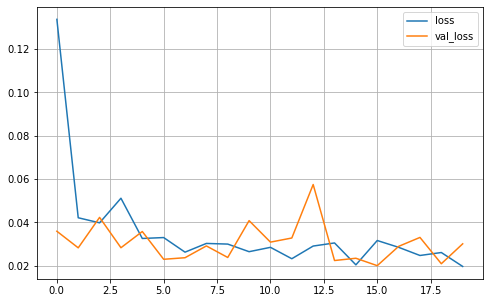

In [6]:
fig, ax = plt.subplots(figsize=(8,5), ncols=1)
ax.plot(history.history["loss"], label="loss")
ax.plot(history.history['val_loss'], label="val_loss")
ax.grid()
ax.legend()

# ax[1].plot(history.history["accuracy"])
# ax[1].plot(history.history["val_accuracy"])
# ax[1].grid()

2.4272776


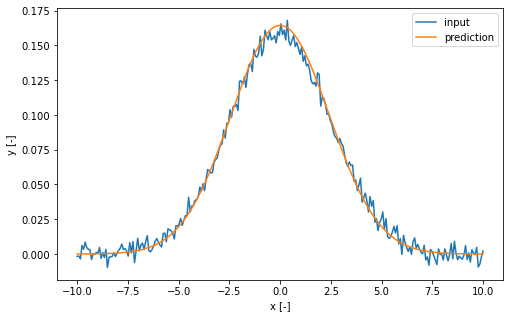

In [9]:
ts = 2.49
gg = gauss(x, sigma=ts, noise=ns)
gg = scaler.transform(np.array([gg]))

print(model.predict(gg)[0][0])

# compare result with prediction
fig, ax = plt.subplots(figsize=(8,5), ncols=1)
ax.plot(x, gauss(x, sigma=ts, noise=ns), label="input")
ax.plot(x, gauss(x, sigma=model.predict(gg)[0][0], noise=False), label="prediction")
ax.set(xlabel="x [-]", ylabel="y [-]")
ax.legend()
